In [1]:
import common
import importlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import socket
import plotting

import matplotlib.style
matplotlib.style.use('classic')

# Show all columns and rows in a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Size of the axis overflow indicators
OVERFLOW_FONT_SIZE = 6

In [2]:
# graphalytics inserts
experiments = "hostname == 'scyper22'"

data_ins = common.import_gfe("view_graphalytics_inserts").query(experiments).copy() # data from the experiments
data_ins["build_frequency"].fillna(pd.Timedelta(0), inplace=True) # replace NaT with 0, otherwise the records are ignored in the group by

data_ins = data_ins.query("((block_size == 512) and library == 'sortledton.3') or library != 'sortledton.3'")

# graphalytics load
data_load = common.import_gfe("view_graphalytics_load").query(experiments).copy()
# shape the dataframe as data_ins
data_load["build_frequency"] = pd.Timedelta(0)
data_load["build_frequency_secs"] = np.NaN
data_load["num_snapshots_created"] = 0
data_load["num_threads_write"] = 0
data_load["block_size"] = -1

data = pd.concat([data_ins, data_load])
data["validate_inserts"].fillna("0", inplace=True)
data["validate_output"].fillna("0", inplace=True)

data = data.query("validate_inserts == '0' and validate_output == '0'")

data = data.groupby(["library", "compiler_family", "graph", "build_frequency","num_threads_read", "num_threads_write", "algorithm"]) \
    .agg(completion_time=("median_secs", "median"), count=("median_secs", "count"), ct_std=("median_secs", "std"))
data["cov"] = data["ct_std"] / data["completion_time"]
#data

List of available executions:

In [3]:
data = data.unstack("algorithm")[("completion_time")]
data.index.set_names("compiler", level=1, inplace=True)

fn_join_threads = lambda grp: ", ".join(map(str, grp.unique()))
data.reset_index().groupby(["library", "compiler"]).agg(num_threads_w=("num_threads_write", fn_join_threads), num_threads_r=("num_threads_read", fn_join_threads))

,,num_threads_w,num_threads_r
library,compiler,,
baseline_v3,gcc,1,0
csr,gcc,0,28
csr-lcc,gcc,0,"20, 28"
csr3,gcc,0,0
csr3-lcc,gcc,0,"0, 20"
csr3-lcc-numa,gcc,0,"0, 1, 2, 4, 8, 14, 28, 42, 56, 20"
g1_v6-ref-ignore-build,gcc,20,0
livegraph3_ro,gcc,20,0
llama8-ref,gcc,16,0


### CSR

In [4]:
csr = data.loc[("csr3-lcc", "gcc")].droplevel([1,2,3])
csr["lcc_std"] = data.loc[("csr3", "gcc")].droplevel([1,2,3]).rename(columns = {"lcc": "lcc_std"})["lcc_std"]
csr_numa = data.loc[("csr3-lcc-numa", "gcc")].droplevel([3])
csr_numa["lcc_std"] = data.loc[("csr3", "gcc")].droplevel([1,2,3]).rename(columns = {"lcc": "lcc_std"})["lcc_std"]
mb_csr = data.loc[("mb-csr.8", "gcc")].droplevel([3])
mb_csr["lcc_std"] = data.loc[("csr3", "gcc")].droplevel([1,2,3]).rename(columns = {"lcc": "lcc_std"})["lcc_std"]
min_csr = mb_csr.combine(csr_numa, np.minimum)
csr = csr[["bfs", "cdlp", "lcc_std", "lcc", "pagerank", "sssp", "wcc"]] # reoder the columns
csr = pd.concat([min_csr], names=["library"], keys=["min_csr"]) # prepend the key `csr`

min_csr

algorithm                                             bfs        cdlp  \
graph          build_frequency num_threads_read                         
com-friendster 0 days          0                 0.970899  177.237292   
dota-league    0 days          0                 0.000727    1.107514   
graph500-22    0 days          0                 0.033258    3.703384   
graph500-24    0 days          0                 0.131544   14.926092   
                               1                 0.683247  265.076148   
                               2                 0.407815  151.534756   
                               4                 0.257636  104.507428   
                               8                 0.182160   66.761944   
                               14                0.150701   49.207798   
                               28                0.130891   22.853231   
                               42                0.127568   20.024884   
                               56                0.125019   16.482074   
graph500-26    0 days          0                 0.480766  119.647970   
                               20                     NaN         NaN   
uniform-24     0 days          0                 0.148202   23.132612   
uniform-26     0 days          0                 0.518993  132.497073   

algorithm                                               lcc   pagerank  \
graph          build_frequency num_threads_read                          
com-friendster 0 days          0                  59.470150  30.603569   
dota-league    0 days          0                  49.816105   0.105036   
graph500-22    0 days          0                   8.417857   0.337325   
graph500-24    0 days          0                  51.627964   1.786068   
                               1                  49.795141  43.030079   
                               2                  49.534646  21.645533   
                               4                  50.496585  11.887173   
                               8                  47.555577   6.165228   
                               14                 50.156191   3.590282   
                               28                 50.199872   2.021653   
                               42                 50.529995   1.892521   
                               56                 49.833207   1.744019   
graph500-26    0 days          0                 309.646945  10.626454   
                               20                       NaN        NaN   
uniform-24     0 days          0                   2.816906   3.309615   
uniform-26     0 days          0                  13.111546  18.350899   

algorithm                                             sssp        wcc  lcc_std  
graph          build_frequency num_threads_read                                 
com-friendster 0 days          0                 49.037404  10.068403      NaN  
dota-league    0 days          0                  0.245215   0.023842      NaN  
graph500-22    0 days          0                  0.739230   0.118526      NaN  
graph500-24    0 days          0                  4.717334   0.576570      NaN  
                               1                 77.103312   9.511662      NaN  
                               2                 36.694916   5.224928      NaN  
                               4                 21.048542   2.771316      NaN  
                               8                 11.193775   1.522926      NaN  
                               14                 7.072612   1.025425      NaN  
                               28                 4.843085   0.634284      NaN  
                               42                 4.603246   0.588273      NaN  
                               56                 4.508682   0.556624      NaN  
graph500-26    0 days          0                 26.432848   3.006076      NaN  
                               20                      NaN        NaN      NaN  
uniform-24     0 days          0                  6.4431

In [5]:
csr_numa

algorithm                                             bfs        cdlp  \
graph          build_frequency num_threads_read                         
com-friendster 0 days          0                 0.970899  177.237292   
dota-league    0 days          0                 0.000727    1.171629   
graph500-22    0 days          0                 0.033258    8.122214   
graph500-24    0 days          0                 0.131544   14.926092   
                               1                 0.683247  373.324473   
                               2                 0.407815  234.239346   
                               4                 0.257636  125.017996   
                               8                 0.182160   83.969908   
                               14                0.150701   57.529616   
                               28                0.130891   22.853231   
                               42                0.127568   37.850341   
                               56                0.125019   32.683516   
graph500-26    0 days          0                 0.480766  140.942144   
                               20                0.496860  226.861359   
uniform-24     0 days          0                 0.148202   23.132612   
uniform-26     0 days          0                 0.518993  180.167332   

algorithm                                               lcc   pagerank  \
graph          build_frequency num_threads_read                          
com-friendster 0 days          0                  60.032766  31.227518   
dota-league    0 days          0                  53.648330   0.105036   
graph500-22    0 days          0                  11.931342   0.397270   
graph500-24    0 days          0                  72.086112   2.688269   
                               1                  72.548028  68.064443   
                               2                  72.519357  35.020005   
                               4                  72.533499  17.824394   
                               8                  72.922245   9.085849   
                               14                 73.008645   5.285354   
                               28                 73.609762   2.866121   
                               42                 73.147645   2.738608   
                               56                 73.414447   2.685850   
graph500-26    0 days          0                 478.273912  15.201051   
                               20                       NaN  21.436688   
uniform-24     0 days          0                   2.816906   3.309615   
uniform-26     0 days          0                  13.111546  18.350899   

algorithm                                              sssp        wcc  \
graph          build_frequency num_threads_read                          
com-friendster 0 days          0                  59.441738  10.068403   
dota-league    0 days          0                   0.245215   0.023842   
graph500-22    0 days          0                   0.739230   0.154064   
graph500-24    0 days          0                   4.827259   0.929016   
                               1                 159.771282  21.737955   
                               2                  74.575479  11.288603   
                               4                  35.056285   5.748596   
                               8                  15.433610   2.965605   
                               14                 10.411468   1.755540   
                               28                  5.882483   0.990796   
                               42                  5.446811   0.947038   
                               56                  4.963374   0.913964   
graph500-26    0 days          0                  26.432848   4.943431   
                               20                 75.860423   6.882225   
uniform-24     0 days          0                   6.443192   1.164549   
uniform-26     0 days          0                  34.104711   6.210624   

algorithm          

In [6]:

mb_csr

algorithm                                             bfs        cdlp  \
graph          build_frequency num_threads_read                         
com-friendster 0 days          0                 1.125382  227.241485   
dota-league    0 days          0                 0.000776    1.107514   
graph500-22    0 days          0                 0.037814    3.703384   
graph500-24    0 days          0                 0.139064   16.663601   
                               1                 1.139631  265.076148   
                               2                 0.572204  151.534756   
                               4                 0.365596  104.507428   
                               8                 0.228776   66.761944   
                               14                0.176003   49.207798   
                               28                0.141009   25.649491   
                               42                0.140005   20.024884   
                               56                0.130761   16.482074   
graph500-26    0 days          0                 0.514324  119.647970   
uniform-24     0 days          0                 0.152608   40.478046   
uniform-26     0 days          0                 0.563581  132.497073   

algorithm                                               lcc   pagerank  \
graph          build_frequency num_threads_read                          
com-friendster 0 days          0                  59.470150  30.603569   
dota-league    0 days          0                  49.816105   0.140827   
graph500-22    0 days          0                   8.417857   0.337325   
graph500-24    0 days          0                  51.627964   1.786068   
                               1                  49.795141  43.030079   
                               2                  49.534646  21.645533   
                               4                  50.496585  11.887173   
                               8                  47.555577   6.165228   
                               14                 50.156191   3.590282   
                               28                 50.199872   2.021653   
                               42                 50.529995   1.892521   
                               56                 49.833207   1.744019   
graph500-26    0 days          0                 309.646945  10.626454   
uniform-24     0 days          0                   3.251787   3.344918   
uniform-26     0 days          0                  14.869173  18.527266   

algorithm                                             sssp        wcc  lcc_std  
graph          build_frequency num_threads_read                                 
com-friendster 0 days          0                 49.037404  16.095385      NaN  
dota-league    0 days          0                  0.404890   0.029735      NaN  
graph500-22    0 days          0                  0.826469   0.118526      NaN  
graph500-24    0 days          0                  4.717334   0.576570      NaN  
                               1                 77.103312   9.511662      NaN  
                               2                 36.694916   5.224928      NaN  
                               4                 21.048542   2.771316      NaN  
                               8                 11.193775   1.522926      NaN  
                               14                 7.072612   1.025425      NaN  
                               28                 4.843085   0.634284      NaN  
                               42                 4.603246   0.588273      NaN  
                               56                 4.508682   0.556624      NaN  
graph500-26    0 days          0                 29.054993   3.006076      NaN  
uniform-24     0 days          0                  9.652527   1.012159      NaN  
uniform-26     0 days          0                 46.767923   7.454135      NaN

In [7]:
compare = mb_csr / csr_numa
compare


algorithm                                             bfs      cdlp       lcc  \
graph          build_frequency num_threads_read                                 
com-friendster 0 days          0                 1.159113  1.282131  0.990628   
dota-league    0 days          0                 1.067400  0.945277  0.928568   
graph500-22    0 days          0                 1.136990  0.455957  0.705525   
graph500-24    0 days          0                 1.057167  1.116407  0.716198   
                               1                 1.667963  0.710042  0.686375   
                               2                 1.403097  0.646923  0.683054   
                               4                 1.419041  0.835939  0.696183   
                               8                 1.255907  0.795070  0.652141   
                               14                1.167895  0.855347  0.686990   
                               28                1.077301  1.122357  0.681973   
                               42                1.097493  0.529054  0.690795   
                               56                1.045929  0.504293  0.678793   
graph500-26    0 days          0                 1.069801  0.848915  0.647426   
                               20                     NaN       NaN       NaN   
uniform-24     0 days          0                 1.029730  1.749826  1.154383   
uniform-26     0 days          0                 1.085913  0.735411  1.134052   

algorithm                                        pagerank      sssp       wcc  \
graph          build_frequency num_threads_read                                 
com-friendster 0 days          0                 0.980019  0.824966  1.598604   
dota-league    0 days          0                 1.340745  1.651161  1.247148   
graph500-22    0 days          0                 0.849108  1.118013  0.769330   
graph500-24    0 days          0                 0.664393  0.977228  0.620624   
                               1                 0.632196  0.482586  0.437560   
                               2                 0.618091  0.492051  0.462850   
                               4                 0.666905  0.600421  0.482086   
                               8                 0.678553  0.725286  0.513530   
                               14                0.679289  0.679310  0.584108   
                               28                0.705362  0.823306  0.640176   
                               42                0.691052  0.845127  0.621171   
                               56                0.649336  0.908391  0.609022   
graph500-26    0 days          0                 0.699060  1.099200  0.608095   
                               20                     NaN       NaN       NaN   
uniform-24     0 days          0                 1.010667  1.498097  0.869142   
uniform-26     0 days          0                 1.009611  1.371304  1.200223   

algorithm                                        lcc_std  
graph          build_frequency num_threads_read           
com-friendster 0 days          0                     NaN  
dota-league    0 days          0                     NaN  
graph500-22    0 days          0                     NaN  
graph500-24    0 days          0                     NaN  
                               1                     NaN  
                               2                     NaN  
                               4                     NaN  
                               8                     NaN  
                               14                    NaN  
                               28                    NaN  
                               42                    NaN  
                               56                    NaN  
graph500-26    0 days          0                     NaN  
                               20                    NaN  
uniform-24     0 days          0                     NaN  
uniform-26     0 days          0                     NaN

### Other systems

In [8]:
stinger = pd.concat( [
    data.loc[("stinger7-ref", "gcc")].droplevel([1, 2, 3])
], names=["library"], keys=["stinger"])
llama = pd.concat( [
    data.loc[("llama8-ref", "gcc", slice(None), "00:00:10", 0, 16)].droplevel([0, 1, 3, 4, 5]) # dynamic scheduling in OpenMP
], names=["library"], keys=["llama"] )
graphone = pd.concat( [
   data.loc[("g1_v6-ref-ignore-build", "gcc", slice(None), slice(None), 0, 20)].droplevel([0, 1, 3, 4, 5])
], names=["library"], keys=["graphone"] )
livegraph = pd.concat( [
    data.loc[("livegraph3_ro", "gcc", slice(None), slice(None), slice(None), 20)].droplevel([0, 1, 3, 4, 5])
], names=["library"], keys=["livegraph"] )
competitors = pd.concat([stinger,llama,graphone, livegraph])
#competitors = pd.concat([stinger]).rename(columns = {"lcc": "lcc_std"})

### Teseo

In [9]:
teseo_lcc = data.loc[("teseo-lcc.12", "gcc")]
teseo_dv_lcc = data.loc[("teseo-lcc-dv.12b", "gcc")]
teseo_lcc["lcc_std"] = np.NaN
teseo_dv_lcc["lcc_std"] = np.NaN

#teseo_std = data.loc[("teseo.12", "gcc")].droplevel([1,2,3]).rename(columns={"lcc": "lcc_std"})
#teseo_std_dv = data.loc[("teseo-dv.12b", "gcc")].droplevel([1,2,3]).rename(columns={"lcc": "lcc_std"})
teseo_logical = pd.concat([ pd.concat([teseo_lcc], axis=1 ) ], names=["library"], keys=["teseo_logical"])
teseo_real = pd.concat([ pd.concat([teseo_dv_lcc], axis=1 ) ], names=["library"], keys=["teseo_real"])

### Sortledton

In [10]:
sortledton3 = data.loc[("sortledton.3", "gcc")]

sortledton = pd.concat([ pd.concat([sortledton3], axis=1 ) ], names=["library"], keys=["sortledton"])
sortledton

algorithm                                                                          bfs  \
library    graph          build_frequency num_threads_read num_threads_write             
sortledton com-friendster 0 days          0                56                 5.053727   
           dota-league    0 days          0                56                 0.001022   
           graph500-22    0 days          0                56                 0.044506   
           graph500-24    0 days          0                56                 0.161151   
                                          1                56                 2.251004   
                                          2                56                 1.196732   
                                          4                56                 0.649321   
                                          8                56                 0.375853   
                                          14               56                 0.259817   
                                          28               56                 0.189098   
                                          42               56                 0.172838   
                                          56               56                 0.165442   
           graph500-26    0 days          0                56                 0.598947   
           uniform-24     0 days          0                56                 0.171751   
           uniform-26     0 days          0                56                 0.633141   

algorithm                                                                           cdlp  \
library    graph          build_frequency num_threads_read num_threads_write               
sortledton com-friendster 0 days          0                56                 260.627118   
           dota-league    0 days          0                56                   1.170734   
           graph500-22    0 days          0                56                   7.326248   
           graph500-24    0 days          0                56                  22.552226   
                                          1                56                 299.748946   
                                          2                56                 184.682129   
                                          4                56                 127.717233   
                                          8                56                  79.770269   
                                          14               56                  61.271376   
                                          28               56                  45.083677   
                                          42               56                  40.576139   
                                          56               56                  28.596117   
           graph500-26    0 days          0                56                 149.688249   
           uniform-24     0 days          0                56                  43.936870   
           uniform-26     0 days          0                56                 173.083578   

algorithm                                                                            lcc  \
library    graph          build_frequency num_threads_read num_threads_write               
sortledton com-friendster 0 days          0                56                  63.085961   
           dota-league    0 days          0                56                  49.754592   
           graph500-22    0 days          0                56                   8.387854   
           graph500-24    0 days          0                56                  47.786827   
                                          1                56                  47.719248   
                                          2                56                  47.459477   
                                          4                56                  47.406385   
                                          8                56               

### Dataset

In [11]:
ds = pd.concat([sortledton, teseo_real])
ds = ds.loc[(slice(None), 'graph500-24', slice(None), slice(1,56), slice(None))]
ds = ds.droplevel([1, 2, 4])
ds = ds.drop("lcc_std", axis=1)
#ds = pd.concat([ds, pd.concat([ds.query("library != 'min_csr' and library != 'mb_csr' and library != 'csr' and library != 'csr_numa'").groupby(by="graph", axis=0).apply(lambda t: t.min())], names=["library"], keys=["best_excl_csr"])])
ds

algorithm                         bfs        cdlp         lcc   pagerank  \
library    num_threads_read                                                
sortledton 1                 2.251004  299.748946   47.719248  69.251388   
           2                 1.196732  184.682129   47.459477  35.202641   
           4                 0.649321  127.717233   47.406385  18.240498   
           8                 0.375853   79.770269   47.418562   9.353620   
           14                0.259817   61.271376   47.467427   5.430477   
           28                0.189098   45.083677   47.546180   2.927871   
           42                0.172838   40.576139   47.605138   2.547351   
           56                0.165442   28.596117   47.755972   2.285832   
teseo_real 1                 2.477717  335.380299  149.688001  71.512588   
           2                 1.379513  193.453958  150.080114  36.657212   
           4                 0.727530   99.964168  149.436904  17.900641   
           8                 0.341868   53.969967  150.323111   9.252844   
           14                0.284892   35.794659  150.721040   5.460750   
           28                0.197098   23.992513  151.875421   2.918418   
           42                0.123485   18.602840  151.562886   2.533185   
           56                0.207798   14.628038  152.151877   2.384461   

algorithm                          sssp        wcc  
library    num_threads_read                         
sortledton 1                  84.912384  14.419586  
           2                  45.850966   7.670225  
           4                  23.812376   3.772318  
           8                  12.679192   2.158049  
           14                  7.731607   1.297791  
           28                  4.564522   0.791350  
           42                  4.209061   0.707081  
           56                  3.972726   0.629789  
teseo_real 1                 180.338834  14.991981  
           2                  88.349026   8.910895  
           4                  45.090447   6.062753  
           8                  23.105856   2.995565  
           14                 13.784456   1.363314  
           28                  7.329904   0.815873  
           42                  6.263139   0.695703  
           56                  5.669257   0.881781

In [12]:
t = csr
t = t.loc[(slice(None), 'graph500-24', slice(None), slice(1,56), slice(None))]
t = t.droplevel([1, 2])
t = t.drop("lcc_std", axis=1)
t

algorithm                      bfs        cdlp        lcc   pagerank  \
library num_threads_read                                               
min_csr 1                 0.683247  265.076148  49.795141  43.030079   
        2                 0.407815  151.534756  49.534646  21.645533   
        4                 0.257636  104.507428  50.496585  11.887173   
        8                 0.182160   66.761944  47.555577   6.165228   
        14                0.150701   49.207798  50.156191   3.590282   
        28                0.130891   22.853231  50.199872   2.021653   
        42                0.127568   20.024884  50.529995   1.892521   
        56                0.125019   16.482074  49.833207   1.744019   

algorithm                      sssp       wcc  
library num_threads_read                       
min_csr 1                 77.103312  9.511662  
        2                 36.694916  5.224928  
        4                 21.048542  2.771316  
        8                 11.193775  1.522926  
        14                 7.072612  1.025425  
        28                 4.843085  0.634284  
        42                 4.603246  0.588273  
        56                 4.508682  0.556624

## Show Speedups

In [1]:
#for (l in ["sortledton", "teseo_real"]):
d = ds.loc["sortledton"]
speedups = d.loc[1] / d
d

d.plot.line()

NameError: name 'ds' is not defined

<AxesSubplot:xlabel='num_threads_read'>

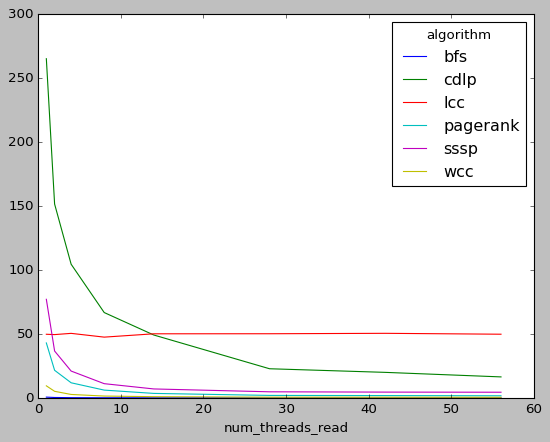

In [14]:
#for (l in ["sortledton", "teseo_real"]):
d = t.loc["min_csr"]
speedups = d.loc[1] / d
d

d.plot.line()

<AxesSubplot:xlabel='num_threads_read'>

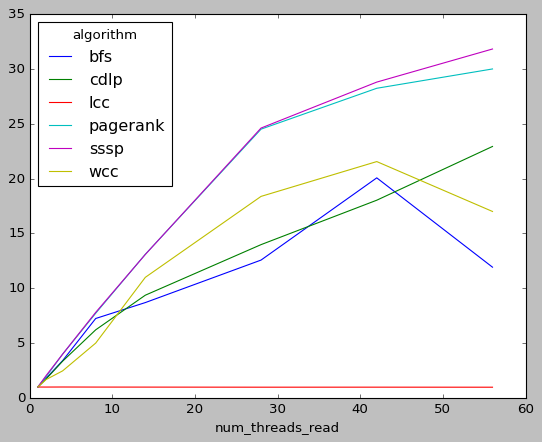

In [15]:
#for (l in ["sortledton", "teseo_real"]):
d = ds.loc["teseo_real"]
speedups = d.loc[1] / d
d

speedups.plot.line()

In [16]:
from scipy import stats
libraries = ["livegraph", "graphone", "teseo_real", "sortledton", "teseo_logical", "llama", "stinger"]
s = speedups.copy()
#summary.drop("csr", inplace=True)
#summary.drop("csr_numa", inplace=True)
#summary.drop("min_csr", inplace=True)
#summary.drop("mb_csr", inplace=True)
#summary.drop("best_excl_csr", inplace=True)
summary = {}
for l in libraries:
    t = stats.gmean(s.loc[l].fillna(10))
    summary[l] = stats.gmean(t)
#summary = summary.gmean(axis=1)

libraries_speedup_summary = {}
#for l in libraries:
    
sortledton = speedups.loc["sortledton"]

me = sortledton.mean()
ma = sortledton.max()
me.mean()
me
ma
summary

KeyError: 'livegraph'

## We summarize the data

There is nothing too exciting in uniform graphs. We drop them.

We check per dataset if the graph500 scale factor makes a huge difference.

* Livegraph: no
* Stinger: no but we cannot load grah500-26 and timeout for LCC on 24
* Graphone: BFS, Pagerank and WCC see less slowdown for big graph datasets
* Sortledton: we see varying speedup for CDLP and SSSP. A slight tedence to less slowdown on bigger graphs
* Teseo: lcc, pagerank and wcc are much worse for scale factor 24
* Teseor real: Tendence to less slow down on bigger graphs
* LLama: no difference

Generally, slow down improves for bigger scale factors. Teseo has a weak spot for scale factor 24.

We remove Graph500-22.

We now compare Friendster with Graph500-26 for each system:

* Sortledton has issues with BFS on friendster
* Teseo logical: wcc, pagerank and sssp have larger slow downs on graph500-26
* Teseo real: we do not have data for friendster yet
* Livegraph: better slow downs on Friendster for all algorithms, most prounounced for BFS
* Graphone: cannot load friendster
* Llama: cannot load either
* Stinger: cannot load either graph

We drop Graph500-26, because there is nothing new to learn over Graph500-24 if Friendster is presented.

We have three graphs to present dota, friendster and graph500-24.
These represent three different sizes, real and generated graphs, weak points of Sorltedton and Teseo.

We compare LCC in a different setting as there are two different algorithms making the biggest difference.

We drop the BFS speedup as it is extreme for many systems accross various graphs. We compare this in another graph.

We compare all systems on the three graphs. 
We drop Graphone from the barchar because with it nothing can be seen, it is too slow. This is due to its access by copying into a vector.
We drop Stinger and Dota league.

We reconsider and show only Graph500-24. We set an ylimit of 8 to cut out WCC on Graphone.




In [ ]:
def format_axes_nospine_left(ax, xscale='linear', yscale='linear'):
    spine_color = 'black'
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(spine_color)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_tick_params(direction='out', color=spine_color)
    
    ax.yaxis.set_tick_params(left=False, right=False, which="major")
    ax.yaxis.grid(b=True, which='both')

    ax.tick_params(axis='both', which='major', pad=0.5)

    return ax

def format_p(p, x_ticks):
    p.set_ylim(0, 9)
    p.set_ylabel("Slowdown")
    p.set_xlabel(None)

    p.set_xticklabels(x_ticks)
    p.legend().remove()
    
    p.axhline(y = 1, color="black", linestyle = '-', linewidth=0.9)


In [ ]:
# Reoder algorithms to fit the order of textual referece
speedups = speedups[["lcc_speedup", "pagerank_speedup", "wcc_speedup", "sssp_speedup", "bfs_speedup", "cdlp_speedup"]]

In [ ]:
## Figure 12a,b,c

OVERFLOW_HEIGHT = 0.825
## Graph500-24
plotting.latexify(columns=1, fig_height=plotting.cm2inch(4.2), font_size=7)
fig, ax = plt.subplots(1, 3, sharey=True)

v = speedups.copy()
v = v.query("graph in 'graph500-24'")
v = v.query("library in ['graphone','sortledton', 'llama', 'teseo_logical', 'teseo_real', 'stinger', 'livegraph']")
v = v.transpose()

colormap=common.set_library_colormap('graph500-24')
sp = ax[0]
p = v.plot.bar(color=colormap, linewidth=0.2, ax=sp, sharey=True, rot=0)

labels = ("LCC \n37m", "PR \n1.77s", "WCC \n0.58s", "SSSP \n4.72s", "BFS \n0.13s", "CDLP \n14.92s",)
format_p(p, labels)
plotting.format_axes(p, categorical_x=True)
sp.set_title("graph500-24", fontsize=8)
sp.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False)


sp.text(0.161, OVERFLOW_HEIGHT, "110x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)
sp.text(0.258, OVERFLOW_HEIGHT, "16x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)
sp.text(0.228, OVERFLOW_HEIGHT, "28x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)

## Friendster
v = speedups.copy()
v = v.query("graph in 'com-friendster'")
v = v.query("library in ['graphone','sortledton', 'llama', 'teseo_logical', 'teseo_real', 'stinger', 'livegraph']")
v = v.transpose()

colormap=common.set_library_colormap('com-friendster')
sp = ax[1]
p = v.plot.bar(color=colormap, legend=None, linewidth=0.2, ax=sp, sharey=True, rot=0)

labels = ("LCC \n14m", "PR \n30.5s", "WCC \n10.07s", "SSSP \n55.35s", "BFS \n0.97s", "CDLP \n177.23s")
format_p(p, labels)
format_axes_nospine_left(p)
sp.set_title("com-friendster", fontsize=8)
sp.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False)
p.set_xlabel("Algorithm and CSR runtime", fontsize=9)

sp.text(0.378, OVERFLOW_HEIGHT, "24x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)

## Dota-League
v = speedups.copy()
v = v.query("graph in ['dota-league']")
v = v.query("library in ['graphone','sortledton', 'llama', 'teseo_logical', 'teseo_real', 'stinger', 'livegraph']")
v = v.transpose()

colormap=common.set_library_colormap('dota-league')
sp = ax[2]
p = v.plot.bar(width=0.7, color=colormap, legend=None, linewidth=0.2, ax=sp, rot=0)

labels = ("LCC \n6m", "PR \n0.1s", "WCC \n0.024s", "SSSP \n0.24s", "BFS \n 0.001s", "CDLP \n 1.17s")
format_p(p, labels)
format_axes_nospine_left(p)

sp.text(0.702, OVERFLOW_HEIGHT, "+11x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)
sp.text(0.786, OVERFLOW_HEIGHT, "261x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)
sp.text(0.83, OVERFLOW_HEIGHT, "16x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)
sp.text(0.741, OVERFLOW_HEIGHT, "36x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)
sp.text(0.886, OVERFLOW_HEIGHT, "14x-4561x", fontsize=OVERFLOW_FONT_SIZE, transform=plt.gcf().transFigure)
sp.set_title("dota-league", fontsize=8)

#fig.text(0.4, 0.015, "Algorithm and CSR runtime", fontsize=9)
plt.tight_layout()
plt.savefig(plotting.base_path + "graphalytics-all.png", dpi=400)

In [ ]:
min_csr.query("graph in 'graph500-24'")

In [ ]:
min_csr.query("graph in 'com-friendster'")

In [ ]:
min_csr.query("graph in 'dota-league'")

In [ ]:
legend_labels = ["Stinger", "Llama", "GraphOne", "Livegraph", "Teseo logical", "Teseo real", "Sortledton"]
legend = p.legend(ncol=7, borderaxespad=0., labels=legend_labels)
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig("../plots/legend.png", dpi=400, bbox_inches=bbox)
